# Ensemble using different models and Conformal Prediction

This notebook combines a regression model with conformal prediction to determine a range of possible values, then uses a classifier model to select the most probable value within that range.

In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import torch
import torch.nn as nn
import numpy as np
import pandas as pd

import pickle
from tqdm import tqdm
from transformers import LongformerTokenizer
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random

from transformers import LongformerModel, LongformerTokenizer
# Import models from the task files
# from task2x_combined_regression import SingleHeadLongformerModel as RegressionModel
# from task2x_combined import SingleHeadLongformerModel as ClassifierModel
# from task2x_combined import FileBasedSingleTaskDataset

In [7]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        
        self.longformer = LongformerModel.from_pretrained('allenai/longformer-base-4096')
        
        # Regression head - outputs a single continuous value
        self.decade_regressor = nn.Sequential(
            nn.Linear(self.longformer.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.longformer(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        
        pooled_output = outputs.last_hidden_state[:, 0, :]
        decade_prediction = self.decade_regressor(pooled_output).squeeze(-1)
        
        return decade_prediction

In [8]:
class ClassifierModel(nn.Module):
    def __init__(self, num_decades=43):
        super(ClassifierModel, self).__init__()
        
        self.longformer = LongformerModel.from_pretrained('allenai/longformer-base-4096')
        
        # Single decade classifier head
        self.decade_classifier = nn.Sequential(
            nn.Linear(self.longformer.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_decades)
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.longformer(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        
        pooled_output = outputs.last_hidden_state[:, 0, :]
        decade_logits = self.decade_classifier(pooled_output)
        
        return decade_logits

In [20]:
def convert_to_absolute_decade(century, decade):
    """Convert century (0-4) and decade (0-9) to absolute decade (0-42)"""
    return century * 10 + decade

class FileBasedSingleTaskDataset(Dataset):
    def __init__(self, file_paths, path, century_labels, decade_labels, tokenizer, max_length=1536):
        self.file_paths = file_paths
        self.path = path
        self.century_labels = century_labels
        self.decade_labels = decade_labels
        self.tokenizer = tokenizer
        self.max_length = max_length            # default 512*3 = 1536
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        century = self.century_labels[idx]
        decade = self.decade_labels[idx]
        
        # Convert to absolute decade label
        absolute_decade = convert_to_absolute_decade(century, decade)
        
        with open(os.path.join(self.path, file_path), 'r', encoding='utf-8') as f:
            text = f.read()
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        encoding['decade_labels'] = torch.tensor(absolute_decade, dtype=torch.long)
        
        return encoding

In [10]:
# Set seeds for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
os.environ['NUMPY_SEED'] = str(SEED)
np.random.default_rng(SEED)

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [32]:
# Load the data from task files
texts_path = './data/Task2/texts'

train_path = os.path.join(texts_path, 'train')
valid_path = os.path.join(texts_path, 'valid')

# Task 2.1
train21 = pd.read_csv('./data/Task2/task2.1/train.csv')
valid21 = pd.read_csv('./data/Task2/task2.1/valid.csv')

train21.rename(columns={'label': 'century'}, inplace=True)
train21['file_name'] = train21['id']
train21['id'] = train21.id.str.replace('train_text', '').str.replace('.txt', '').astype(int)
train21.set_index('id', inplace=True)

valid21.rename(columns={'label': 'century'}, inplace=True)
valid21['file_name'] = valid21['id']
valid21['id'] = valid21.id.str.replace('valid_text', '').str.replace('.txt', '').astype(int)
valid21.set_index('id', inplace=True)

# Task 2.2
train22 = pd.read_csv('./data/Task2/task2.2/train.csv')
valid22 = pd.read_csv('./data/Task2/task2.2/valid.csv')

train22.rename(columns={'label': 'century'}, inplace=True)
train22['file_name'] = train22['id']
train22['id'] = train22.id.str.replace('train_text', '').str.replace('.txt', '').astype(int)
train22.set_index('id', inplace=True)

valid22.rename(columns={'label': 'century'}, inplace=True)
valid22['file_name'] = valid22['id']
valid22['id'] = valid22.id.str.replace('valid_text', '').str.replace('.txt', '').astype(int)
valid22.set_index('id', inplace=True)

with open('blacklist.pkl', 'rb') as f:
    blacklist = pickle.load(f)

# Filter the data similar to the task files
blacklist_train = blacklist['train']
blacklist_valid = blacklist['valid']

X_train_21, y_train_21, X_train_22, y_train_22 = [], [], [], []
X_valid_21, y_valid_21, X_valid_22, y_valid_22 = [], [], [], []

# Process training data
for idx, row in train21.iterrows():
    #if idx in blacklist_train:
    #    continue
        
    file_name = row.file_name
    century = row.century
    
    with open(os.path.join(texts_path, file_name), 'r') as file:
        text = file.read()
    if 'gutenberg' in text.lower() and 'project' in text.lower():
        continue
        
    X_train_21.append(file_name)
    y_train_21.append(century-1)

# Process validation data
for idx, row in valid21.iterrows():
    #if idx in blacklist_valid:
    #    continue
        
    file_name = row.file_name
    century = row.century
    
    with open(os.path.join(texts_path, file_name), 'r') as file:
        text = file.read()
    if 'gutenberg' in text.lower() and 'project' in text.lower():
        continue
        
    X_valid_21.append(file_name)
    y_valid_21.append(century-1)

# Process task2.2 data
for idx, row in train22.iterrows():
    #if idx in blacklist_train:
    #    continue
        
    file_name = row.file_name
    century = row.century
    
    with open(os.path.join(texts_path, file_name), 'r') as file:
        text = file.read()
    if 'gutenberg' in text.lower() and 'project' in text.lower():
        continue
        
    X_train_22.append(file_name)
    y_train_22.append(century-1)

for idx, row in valid22.iterrows():
    #if idx in blacklist_valid:
    #    continue
        
    file_name = row.file_name
    century = row.century
    
    with open(os.path.join(texts_path, file_name), 'r') as file:
        text = file.read()
    if 'gutenberg' in text.lower() and 'project' in text.lower():
        continue
        
    X_valid_22.append(file_name)
    y_valid_22.append(century-1)

print(f"Training samples: {len(X_train_21)}")
print(f"Validation samples: {len(X_valid_21)}")

Training samples: 178221
Validation samples: 42724


## Load Pre-trained Models

In [46]:
# Load models
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

# Load regression model
regression_model = RegressionModel()
regression_model_path = 'old_models/task2x/best_single_head_regression_model_epoch_4.pt'
regression_model.load_state_dict(torch.load(regression_model_path, map_location=device))
regression_model.to(device)
regression_model.eval()
print("Regression model loaded")

# Load classifier model
classifier_model = ClassifierModel()
classifier_model_path = 'old_models/task2x/best_single_head_model.pt'
classifier_model.load_state_dict(torch.load(classifier_model_path, map_location=device))
classifier_model.to(device)
classifier_model.eval()
print("Classifier model loaded")

Regression model loaded
Classifier model loaded


## Prepare Data for Conformal Prediction

In [48]:
from sklearn.model_selection import train_test_split

X_test_main, X_calib, y_test21_main, y_calib21, y_test22_main, y_calib22 = train_test_split(
    X_valid_21, y_valid_21, y_valid_22, test_size=0.2, random_state=42
)

# Create datasets
calib_dataset = FileBasedSingleTaskDataset(X_calib, texts_path, y_calib21, y_calib22, tokenizer)
valid_dataset = FileBasedSingleTaskDataset(X_test_main, texts_path, y_test21_main, y_test22_main, tokenizer)

# Create dataloaders
batch_size = 16
calib_dataloader = DataLoader(calib_dataset, batch_size=batch_size, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

## Implementing Conformal Prediction

In [49]:
def get_regression_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            preds = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['decade_labels'].cpu().numpy())
            
    return np.array(all_preds), np.array(all_labels)

def get_classifier_predictions(model, dataloader):
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            probs = torch.nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['decade_labels'].cpu().numpy())
            
    return np.array(all_probs), np.array(all_preds), np.array(all_labels)

In [55]:
print("Getting regression predictions on calibration set...")
calib_reg_preds, calib_labels = get_regression_predictions(regression_model, calib_dataloader)

print("Getting classifier predictions on calibration set...")
calib_class_probs, calib_class_preds, _ = get_classifier_predictions(classifier_model, calib_dataloader)

Getting regression predictions on calibration set...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [05:38<00:00,  1.58it/s]


Getting classifier predictions on calibration set...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 535/535 [05:36<00:00,  1.59it/s]


In [58]:
# Compute nonconformity scores for conformal prediction
def compute_nonconformity_scores(predictions, labels):
    # Use absolute error as nonconformity score for regression
    return np.abs(predictions - labels)

# Get nonconformity scores on calibration set
nonconformity_scores = compute_nonconformity_scores(calib_reg_preds, calib_labels)

# Function to compute prediction intervals based on desired confidence level
def get_prediction_intervals(pred, nonconformity_scores, confidence_level=0.9):
    # Sort nonconformity scores
    sorted_scores = np.sort(nonconformity_scores)
    
    # Find the threshold for the given confidence level
    n = len(sorted_scores)
    # Add 1 to ensure valid index and adjust confidence level to be conservative
    index = int(np.ceil((n+1) * confidence_level)) - 1
    index = min(index, n-1)  # Ensure index is valid
    threshold = sorted_scores[index]
    
    # Calculate prediction intervals
    lower_bound = np.floor(pred - threshold).astype(int)
    upper_bound = np.ceil(pred + threshold).astype(int)
    
    # Ensure values are within valid range (0 to 42)
    lower_bound = np.maximum(lower_bound, 0)
    upper_bound = np.minimum(upper_bound, 42)
    
    return lower_bound, upper_bound

In [57]:
# Get predictions for the validation set
print("Getting regression predictions on validation set...")
valid_reg_preds, valid_labels = get_regression_predictions(regression_model, valid_dataloader)

print("Getting classifier predictions on validation set...")
valid_class_probs, valid_class_preds, _ = get_classifier_predictions(classifier_model, valid_dataloader)

# Compute prediction intervals using conformal prediction
confidence_level = 0.9  # 90% confidence interval
lower_bounds, upper_bounds = get_prediction_intervals(valid_reg_preds, nonconformity_scores, confidence_level)

# Print some examples of prediction intervals
print("\nSample prediction intervals:")
for i in range(min(10, len(valid_reg_preds))):
    print(f"True: {valid_labels[i]}, Reg Pred: {valid_reg_preds[i]:.2f}, Interval: [{lower_bounds[i]}, {upper_bounds[i]}]")

Getting regression predictions on validation set...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2137/2137 [22:30<00:00,  1.58it/s]


Getting classifier predictions on validation set...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2137/2137 [22:28<00:00,  1.58it/s]


Sample prediction intervals:
True: 25, Reg Pred: 26.94, Interval: [24, 30]
True: 27, Reg Pred: 28.35, Interval: [26, 31]
True: 24, Reg Pred: 25.26, Interval: [22, 28]
True: 24, Reg Pred: 24.46, Interval: [22, 27]
True: 23, Reg Pred: 23.94, Interval: [21, 27]
True: 23, Reg Pred: 24.60, Interval: [22, 27]
True: 28, Reg Pred: 29.29, Interval: [27, 32]
True: 31, Reg Pred: 29.55, Interval: [27, 32]
True: 23, Reg Pred: 24.46, Interval: [22, 27]
True: 29, Reg Pred: 29.54, Interval: [27, 32]


## Combine Regression with Conformal Prediction and Classification

In [70]:
def ensemble_prediction(reg_pred, lower_bound, upper_bound, class_probs):
    # Create an interval of integers from lower_bound to upper_bound
    interval = np.arange(lower_bound, upper_bound + 1)
    
    # Filter probabilities within the interval
    filtered_probs = np.array([class_probs[i] if i in interval else 0 for i in range(len(class_probs))])
    
    # If no valid probabilities in interval, return the regression prediction rounded to nearest integer
    if np.sum(filtered_probs) == 0:
        return int(np.floor(reg_pred))
    
    # Otherwise, return the class with the highest probability within the interval
    return np.argmax(filtered_probs)

# Apply ensemble prediction to each sample
ensemble_preds = [
    ensemble_prediction(reg_pred, lb, ub, class_probs) 
    for reg_pred, lb, ub, class_probs in zip(valid_reg_preds, lower_bounds, upper_bounds, valid_class_probs)
]

ensemble_preds = np.array(ensemble_preds)

In [75]:
ensemble_preds

array([25, 27, 24, ..., 25, 29, 25])

In [78]:
np.mean([ l ==p for l, p in zip(valid_labels, ensemble_preds)])

0.8408379414260219

In [81]:
# Evaluate results
from sklearn.metrics import mean_absolute_error, accuracy_score

# Calculate various metrics
reg_mae = mean_absolute_error(valid_labels, np.floor(valid_reg_preds).astype(int))
class_mae = mean_absolute_error(valid_labels, valid_class_preds)
ensemble_mae = mean_absolute_error(valid_labels, ensemble_preds)

reg_acc = accuracy_score(valid_labels, np.floor(valid_reg_preds).astype(int))
class_acc = accuracy_score(valid_labels, valid_class_preds)
ensemble_acc = accuracy_score(valid_labels, ensemble_preds)

print("\nEvaluation Metrics:")
print(f"Regression Model - MAE: {reg_mae:.4f}, Accuracy: {reg_acc:.4f}")
print(f"Classification Model - MAE: {class_mae:.4f}, Accuracy: {class_acc:.4f}")
print(f"Ensemble Model - MAE: {ensemble_mae:.4f}, Accuracy: {ensemble_acc:.4f}")

# Coverage evaluation (check if true labels are within the prediction intervals)
interval_coverage = np.mean([(lb <= label <= ub) for lb, label, ub in zip(lower_bounds, valid_labels, upper_bounds)])
avg_interval_size = np.mean(upper_bounds - lower_bounds + 1)

print(f"\nConformal Prediction - Coverage: {interval_coverage:.4f}, Avg. Interval Size: {avg_interval_size:.2f}")


Evaluation Metrics:
Regression Model - MAE: 1.0656, Accuracy: 0.4246
Classification Model - MAE: 0.6446, Accuracy: 0.8507
Ensemble Model - MAE: 0.6408, Accuracy: 0.8408

Conformal Prediction - Coverage: 0.9521, Avg. Interval Size: 6.55


## Visualize Results

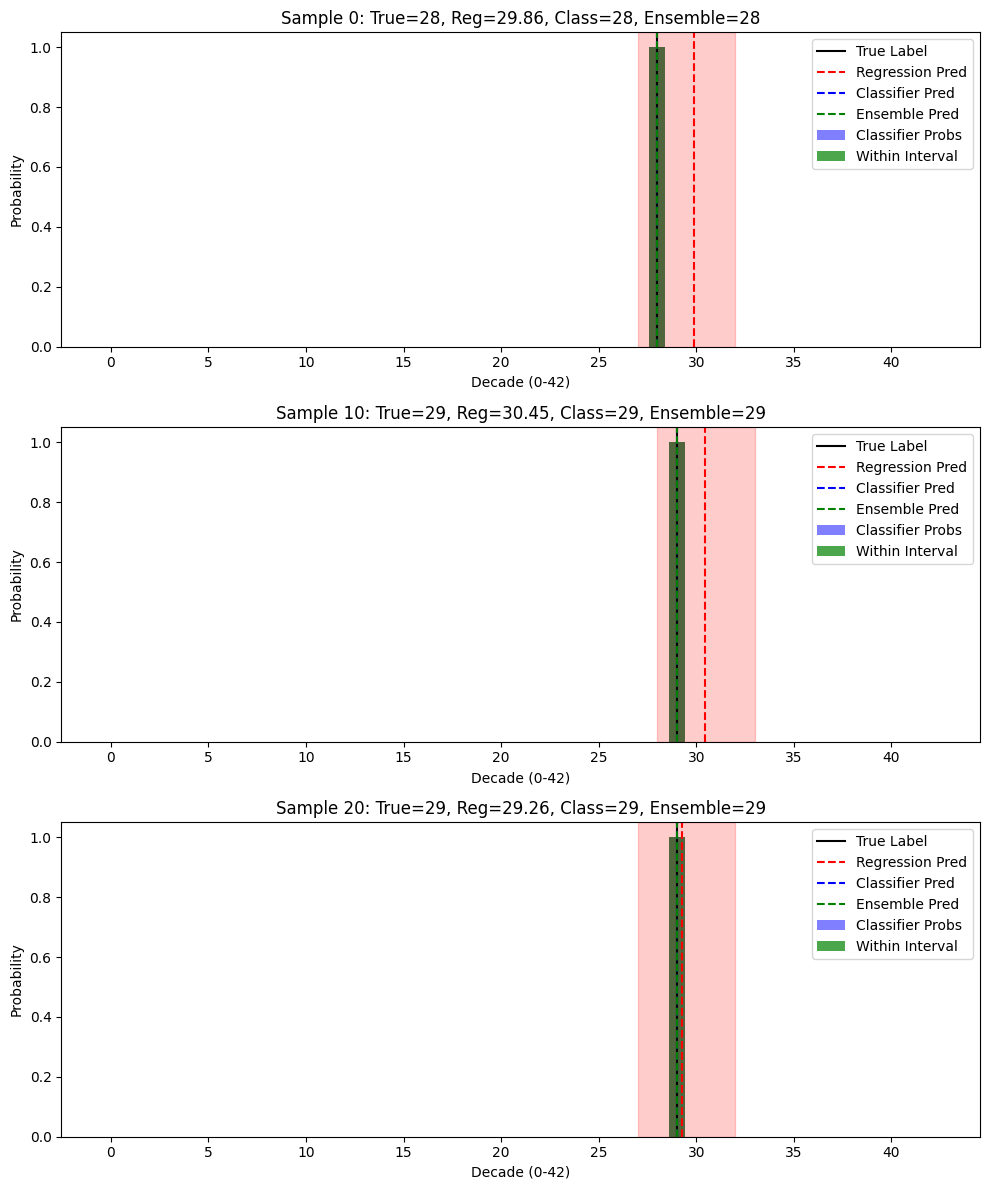

In [26]:
# Plot some example predictions
def plot_predictions(sample_indices):
    fig, axes = plt.subplots(len(sample_indices), 1, figsize=(10, 4 * len(sample_indices)))
    if len(sample_indices) == 1:
        axes = [axes]
    
    for i, idx in enumerate(sample_indices):
        ax = axes[i]
        # Plot classifier probabilities
        ax.bar(range(43), valid_class_probs[idx], alpha=0.5, color='blue', label='Classifier Probs')
        
        # Highlight prediction interval
        interval = np.arange(lower_bounds[idx], upper_bounds[idx] + 1)
        filtered_probs = np.array([valid_class_probs[idx][j] if j in interval else 0 for j in range(43)])
        ax.bar(range(43), filtered_probs, alpha=0.7, color='green', label='Within Interval')
        
        # Add lines for various predictions
        ax.axvline(x=valid_labels[idx], color='black', linestyle='-', label='True Label')
        ax.axvline(x=valid_reg_preds[idx], color='red', linestyle='--', label='Regression Pred')
        ax.axvline(x=valid_class_preds[idx], color='blue', linestyle='--', label='Classifier Pred')
        ax.axvline(x=ensemble_preds[idx], color='green', linestyle='--', label='Ensemble Pred')
        
        # Add shaded area for prediction interval
        ax.axvspan(lower_bounds[idx], upper_bounds[idx], alpha=0.2, color='red')
        
        ax.set_title(f"Sample {idx}: True={valid_labels[idx]}, Reg={valid_reg_preds[idx]:.2f}, Class={valid_class_preds[idx]}, Ensemble={ensemble_preds[idx]}")
        ax.set_xticks(range(0, 43, 5))
        ax.set_xlabel('Decade (0-42)')
        ax.set_ylabel('Probability')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Plot 3 examples
plot_predictions([0, 10, 20])

In [27]:
# Save the ensemble predictions to a file
output_data = pd.DataFrame({
    'file_name': X_valid_21,
    'true_label': valid_labels,
    'reg_pred': np.round(valid_reg_preds).astype(int),
    'class_pred': valid_class_preds,
    'ensemble_pred': ensemble_preds,
    'lower_bound': lower_bounds,
    'upper_bound': upper_bounds
})

output_data.to_csv('reg_class_ensemble_predictions.csv', index=False)
print("Predictions saved to 'reg_class_ensemble_predictions.csv'")

Predictions saved to 'reg_class_ensemble_predictions.csv'
